<a href="https://colab.research.google.com/github/dyjdlopez/intro_2_quantum/blob/main/cuda-q/11-quantum_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11 Quantum Machine Learning - Quantum Neural Networks
$_{\text{Made by: @dyjdlopez}}$


In this notebook we will look at how to develop quantum neural networks using CUDA-Q. Quantum neural networks (QNNs) are specialized parametric quantum circuits that is aimed to extract features from data using quantum encoding and quantum principles such as superposition, entanglement, and probability.

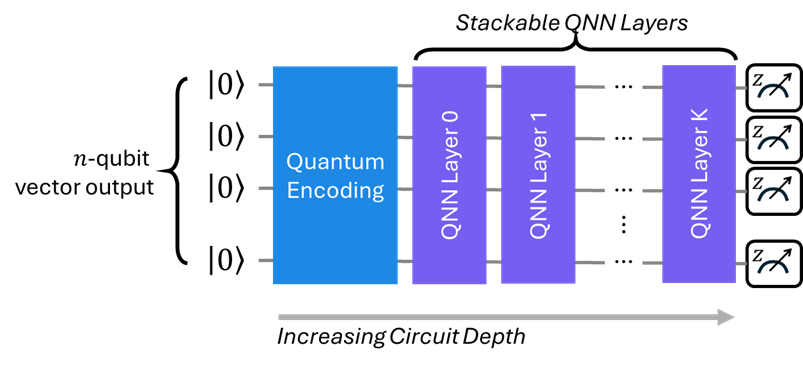

A QNN basically has four parts. The first part is the quantum encoding circuit that transforms classical data into quantum data. This is usually done using Amplitude or Phase encoding. The next part are QNN layers which includes two sub-parts: parametrized quantum circuits and quantum correlation layers for feature extraction. The last part of the QNN architecture is the measurement layer which converts quantum data back to classical data.

In the next few sections, you will see how to implement these pieces of algorthims to build a QNN layer.

In [ ]:
!pip install cudaq==0.9.1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 MB 5.8 MB/s eta 0:00:00
  Created wheel for cudaq: filename=cudaq-0.9.1-py3-none-any.whl size=6853 sha256=9d784c0b6017c899010a296d8aea49a1051d994f6edc1700cdcc031ab792c299
  Stored in directory: /root/.cache/pip/wheels/b0/ee/32/0ac9053509c0ba31e4bac6122454996a9a4e4d6523b1918d04
Successfully built cudaq


In [ ]:
import cudaq
from cudaq import spin

import math
import numpy as np

# 1. Quantum Encoding
Quantum encoding algorithms are set of circuits that encode classical information as the phase or amplitude of a statevector. This statevector is what we use then to extract information from. Some encoding techniques include Basis, Phase Encoding, Amplitude Encoding, and much more. You can check more about quantm encoding using these out: [Comparison of Encoding Methods](https://arxiv.org/pdf/2311.10375).

A simple implementation of the phase encoding is using rotation gates with the input data/vector. We can apply the rotation gates like the $R_y$ gate to each available qubits.

In [ ]:
@cudaq.kernel
def q_encoder():

    qubits = cudaq.qvector(1)

    ry(np.pi, qubits) ## input vector, qubit assignment
print(cudaq.get_state(q_encoder))

SV: [(-4.37114e-08,0), (1,0)]



In [ ]:
input_vector = np.array([-np.pi, 1/2])
@cudaq.kernel
def q_encoder(input_vector : np.ndarray):

    qubits = cudaq.qvector(2)

    ry(input_vector[0], qubits[0])
    ry(input_vector[1], qubits[1])

    rx(input_vector[0], qubits[0])
    rx(input_vector[1], qubits[1])

print(cudaq.get_state(q_encoder, input_vector))

SV: [(-0.0612087,-0.938791), (3.83604e-08,-4.37114e-08), (-0.239713,-0.239713), (0,-2.09564e-08)]



# 2. Feature Extraction
The feature extraction layer has two sub-parts. The first part pertains to the the parameterized unitary that "learns" the weights for a circuit through adjusting the phases of a rotation gate. The quantum analogue of the classical weight sharing propert of neural networks are realized through quantum correlations which are done by entangling the qubits. Let's try to encode this in the next few cells.

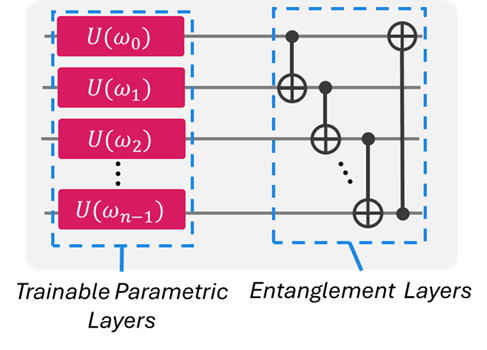

In [ ]:
@cudaq.kernel
def q_feature_extract(weights : np.ndarray):

    qubits = cudaq.qvector(2)

    ry(weights[0], qubits[0])
    ry(weights[1], qubits[1])

    rz(weights[2], qubits[0])
    rz(weights[3], qubits[1])


weight_vector = np.array([0.01, -0.21, 2.1, 0.001])
print(cudaq.get_state(q_feature_extract, weight_vector))
print(cudaq.draw(q_feature_extract, weight_vector))

SV: [(0.494393,-0.862882), (0.0024763,0.00431197), (-0.0521938,0.0908849), (-0.000260517,-0.000454689)]

     ╭──────────╮  ╭─────────╮ 
q0 : ┤ ry(0.01) ├──┤ rz(2.1) ├─
     ├──────────┴╮╭┴─────────┴╮
q1 : ┤ ry(-0.21) ├┤ rz(0.001) ├
     ╰───────────╯╰───────────╯



In [ ]:
@cudaq.kernel
def q_feature_extract(weights : np.ndarray):

    qubits = cudaq.qvector(2)

    ry(weights[0], qubits[0])
    ry(weights[1], qubits[1])

    rz(weights[2], qubits[0])
    rz(weights[3], qubits[1])


    ## Adding quantum correlations
    x.ctrl(qubits[0], qubits[1])
    x.ctrl(qubits[1], qubits[0])

weight_vector = np.array([0.01, -0.21, 2.1, 0.001])
print(cudaq.get_state(q_feature_extract, weight_vector))
print(cudaq.draw(q_feature_extract, weight_vector))

SV: [(0.494393,-0.862882), (-0.000260517,-0.000454689), (0.0024763,0.00431197), (-0.0521938,0.0908849)]

     ╭──────────╮  ╭─────────╮      ╭───╮
q0 : ┤ ry(0.01) ├──┤ rz(2.1) ├───●──┤ x ├
     ├──────────┴╮╭┴─────────┴╮╭─┴─╮╰─┬─╯
q1 : ┤ ry(-0.21) ├┤ rz(0.001) ├┤ x ├──●──
     ╰───────────╯╰───────────╯╰───╯     



# 3. Quantum to Classical Decoding
To decode the quantum statevectors to classical observations, we can use the measurement gates to collapse the quantum states. Normally, the statevectors are measured in the Z basis but this can be modified by defining your own observable using a Hamiltonian.

In [ ]:
## Define an observable
hamiltonian = spin.z(0)

## Let's try on a sample single-qubit QNN layer
@cudaq.kernel
def QNN_1(input_vector: np.ndarray, weights : np.ndarray):

    qubit = cudaq.qvector(1)

    ## Define the quantum encoder
    ry(input_vector[0], qubit[0])

    ## Define the feature extractor
    ry(weights[0], qubit[0])
    rz(weights[1], qubit[0])

    ## No quantum correlations need to be done for a 1-qubit QNN

input_vector = np.array([2.3])
weights = np.array([-1.71, 0.28])

print(cudaq.get_state(QNN_1, input_vector, weights))

SV: [(0.947441,-0.133515), (0.287895,0.0405707)]



In [ ]:
QNN_expectation = cudaq.observe(QNN_1, hamiltonian, input_vector, weights).expectation()
QNN_expectation

0.83094073086977

In [ ]:
## Now let's design for a 2-qubit QNN


## Let's try on a sample single-qubit QNN layer
@cudaq.kernel
def QNN_2(input_vector: np.ndarray, weights : np.ndarray):

    qubits = cudaq.qvector(2)

    ## Define the quantum encoder
    ry(input_vector[0], qubits[0])
    ry(input_vector[1], qubits[1])

    ## Define the feature extractor
    ry(weights[0], qubits[0])
    ry(weights[1], qubits[1])

    rz(weights[2], qubits[0])
    rz(weights[3], qubits[1])

    ## Adding quantum correlations
    x.ctrl(qubits[0], qubits[1])
    x.ctrl(qubits[1], qubits[0])

input_vector = np.array([2.3, -3.14])
weights = np.array([-1.71, 0.28, 0.01, 4.62])

print(cudaq.get_state(QNN_2, input_vector, weights))
print(cudaq.draw(QNN_2, input_vector, weights))

SV: [(-0.0909523,-0.0987724), (0.194994,-0.21176), (-0.0273358,-0.0302885), (0.63471,-0.703267)]

      ╭─────────╮ ╭───────────╮╭──────────╮     ╭───╮
q0 : ─┤ ry(2.3) ├─┤ ry(-1.71) ├┤ rz(0.01) ├──●──┤ x ├
     ╭┴─────────┴╮├──────────┬╯├──────────┤╭─┴─╮╰─┬─╯
q1 : ┤ ry(-3.14) ├┤ ry(0.28) ├─┤ rz(4.62) ├┤ x ├──●──
     ╰───────────╯╰──────────╯ ╰──────────╯╰───╯     



In [ ]:
## Define an observable
hamiltonian = [spin.z(0), spin.z(1)]

def expectation(kernel, input_vector: np.ndarray, weights : np.ndarray):
  # qubit_count = [qubit_count for _ in range(weights.shape[0])]
  results = cudaq.observe(kernel, hamiltonian, input_vector,
                                weights)
  exp_vals = [results[i].expectation() for i in range(len(results))]

  return np.asarray(exp_vals)

expectation(QNN_2, input_vector, weights)

array([-0.96061416, -0.79821343])

# 4. Backpropagation

First we need to understand how are gradients computed considering quantum states.

One way of computing the gradient of quantum circuits and their statevectors $\nabla_{\theta} f(x;\theta)$ is using the parameter-shift rule. The parameter-shift rule simply computes the difference between the a quantum circuit if we shift its parameters by a certain phase. We compute it by:
$$
\nabla_{\theta} f(x;\theta) = \frac{1}{2}\left[ f(x;\theta+\phi) - f(x;\theta-\phi)\right]
$$

A good illustration of the parameter-shift rule can be seen in this image by Torchquantum:
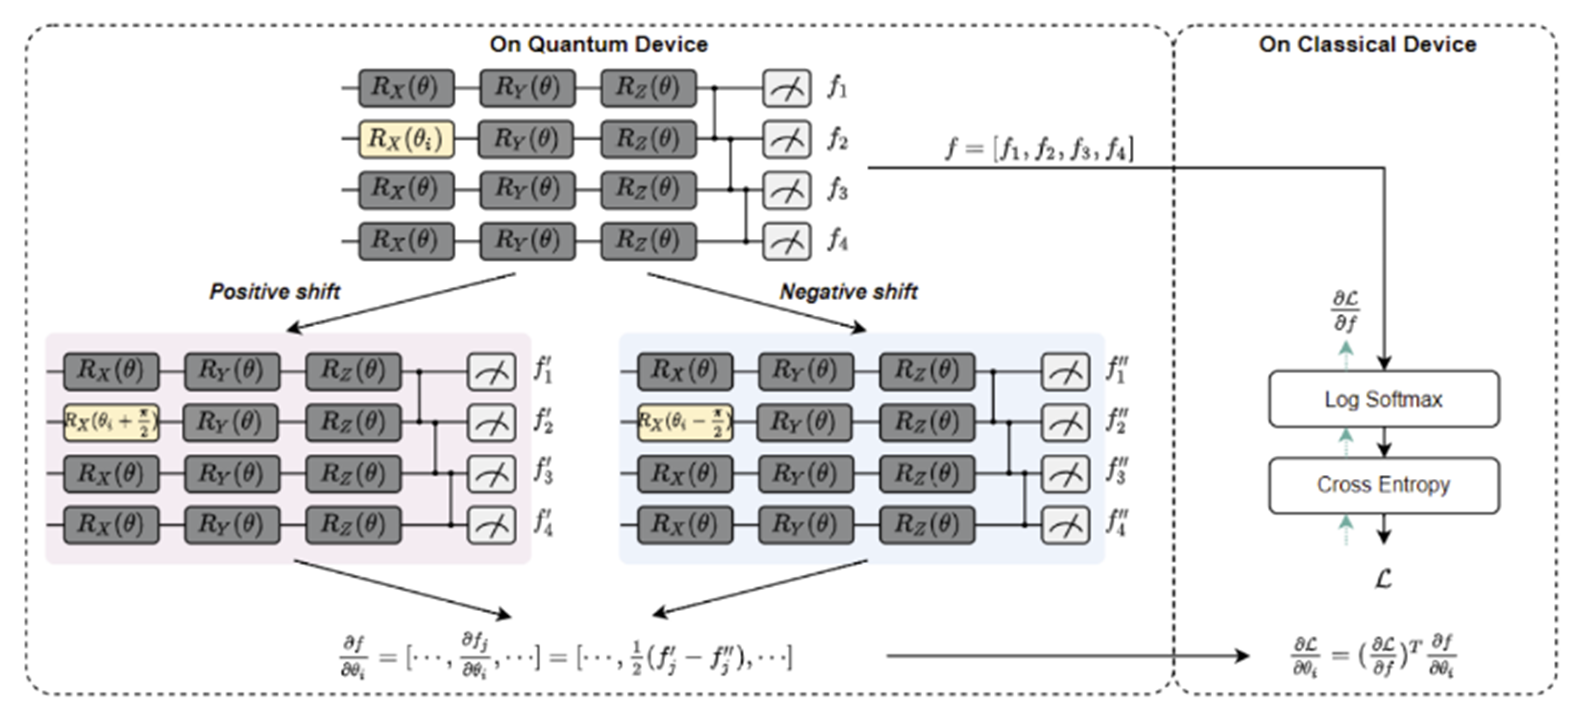

In [ ]:
shift = np.pi/2
exp_vals = expectation(QNN_2, input_vector, weights) ## from a feed-forward routine

## initialize the gradient
gradients = np.zeros(weights.shape)

## Shift the parameters
thetas_plus = weights + shift
thetas_minus = weights - shift

## Apply the shifted parameters
grad_plus = expectation(QNN_2, input_vector, thetas_plus)
grad_minus = expectation(QNN_2, input_vector, thetas_minus)

## Compute for the quantum circuit gradients
qgradient = (grad_plus - grad_minus)/2

## Compute the gradients given a theoretical error
theoretical_error = np.array([[-1,1],[1,0.5]])
gradient = theoretical_error @ qgradient

gradient

array([-0.27788591,  0.27788596])

# Up Next: Gradient Optimization


The success of classical neural networks in the past few decades relied on the concept of weight updates through backpropagation. We can do a similar routine in quantum computing by applying concepts of variational quantum algorithms.

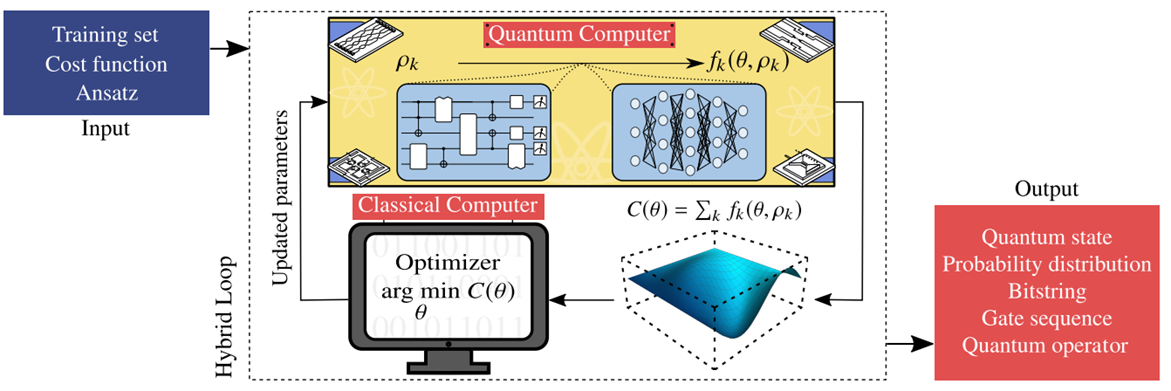


Variational quantum algorithms (VQAs) work by updating the parameters of a quantum circuit aks the ansatz to minimize the expectation error given a case. A bit similar to the concept of model optimization. However in VQAs, there is driven by an external classical optimizer. But how can we do gradient optimization in quantum computing similar to classical neueral networks?

## Exercise
Try to implement a gradient optimization scheme using any existing value minimization function in SciPy. The weights can be updated using the classical weight update formula:
$$\omega_{i+1}=\omega_i+\eta\frac{dJ}{d_\hat{\omega}}$$

Where $J$ is the model error and $\eta$ is the learning rate.

---

---
$$_{\text{END OF FILE}}$$
$$_{\text{D.J.D. Lopez | © 2025}}$$